# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
import time
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor


import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("/datasets/autos.csv")

In [4]:
df.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
258509,2016-03-08 17:39:44,920,NaN,2016,NaN,82,zafira,150000,8,gasoline,opel,no,2016-03-08 00:00:00,0,45355,2016-03-09 08:45:48
104850,2016-03-08 18:25:20,3200,small,2003,manual,58,corsa,150000,3,petrol,opel,no,2016-03-08 00:00:00,0,56294,2016-03-12 19:18:18
32012,2016-04-05 00:53:59,2350,convertible,2001,manual,136,2_reihe,150000,7,petrol,peugeot,no,2016-04-04 00:00:00,0,68199,2016-04-07 09:46:50
117012,2016-03-06 23:47:00,300,small,1998,manual,55,polo,150000,2,petrol,volkswagen,yes,2016-03-06 00:00:00,0,25727,2016-03-10 16:46:51
186458,2016-04-04 11:45:23,6000,wagon,2008,manual,140,passat,150000,10,gasoline,volkswagen,no,2016-04-04 00:00:00,0,23970,2016-04-04 11:45:23
157171,2016-03-18 20:51:37,5500,NaN,2016,NaN,231,5er,150000,6,NaN,bmw,NaN,2016-03-18 00:00:00,0,65934,2016-03-19 19:28:10
283979,2016-03-16 11:42:56,10,NaN,2000,NaN,0,NaN,150000,1,NaN,sonstige_autos,NaN,2016-03-16 00:00:00,0,48366,2016-03-21 11:15:18
104687,2016-03-16 08:54:32,1200,sedan,2000,manual,106,other,150000,3,petrol,fiat,NaN,2016-03-16 00:00:00,0,15834,2016-04-06 01:44:37
116770,2016-03-27 14:55:50,3500,small,2010,manual,82,spark,90000,2,petrol,chevrolet,no,2016-03-27 00:00:00,0,21726,2016-04-07 11:45:19
97968,2016-04-02 02:36:42,6499,sedan,2006,manual,105,golf,150000,6,gasoline,volkswagen,no,2016-04-02 00:00:00,0,44809,2016-04-04 05:47:01


In [5]:
df.shape

(354369, 16)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:

- Price — цена (евро)

#### Проверим дубликаты

In [7]:
df.duplicated().sum()

4

удалим

In [8]:
df = df.drop_duplicates()
df.duplicated().sum()

0

дубликатов больше нет

Приведем названия признаков к нижнему регистру 

In [9]:
df.columns = df.columns.str.lower()
df.columns = [ 'date_crawled' , 'price' , 'vehicle_type' , 'registration_year' , 'gearbox' ,
               'power' , 'model' , 'kilometer' , 'registration_month' , 'fuel_type' , 'brand' ,
               'not_repaired' , 'date_created' , 'number_of_pictures' , 'postal_code' ,
               'last_seen' ]

#### Пропуски


In [10]:
df.isna().mean().sort_values(ascending=False)

not_repaired          0.200793
vehicle_type          0.105795
fuel_type             0.092828
gearbox               0.055968
model                 0.055607
date_crawled          0.000000
price                 0.000000
registration_year     0.000000
power                 0.000000
kilometer             0.000000
registration_month    0.000000
brand                 0.000000
date_created          0.000000
number_of_pictures    0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

Пропуски есть в 5 признаках - not_repaired, vehicle_type, fuel_type, gearbox, model

- not_repaired - возможно клиент не сообщил о факте отсутствия ремонта, либо автомобиль подвергался ремонту, и данные отсутствуют в зависимости от неизвестных факторов.  
- vehicle_type - вероятно клиент не сообщил о типе кузова
- fuel_type - клиент не заполнил информацию либо не знал
- gearbox, model - клиент не заполнил информацию либо не знал

Некоторые из признаков с пропусками действиетльно важны и сильно влияют на целевой признак (цену) поэтому удалять пропуски не будем, а заменим их значениями `unknown`


In [11]:
nan_columns = ['not_repaired', 'vehicle_type', 'fuel_type', 'gearbox', 'model']
df[nan_columns] = df[nan_columns].fillna('unknown')

Проверим значения

In [12]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Имеются  аномалии в признаки `registration_year` - min не может быть равен 1000.0, а max 9999
Также для признака `power` аномальное значения мощности (max) - 20 000 л.с. - это возможно только для реактивных двигателей, и данные значения выбиваются из общей массы - большая часть сета - автомобили с мощностью до 143 л.с.
В столбце `price` есть аномальное значение 0. В столбце `kilometer` странные значение 150 000 км. Возможно на сайте стоит какое-то огрничение или значение по умолчанию в 150000.


Удалим неинформативные признаки, ненужные при обучении моделей.

- date_crawled — дата скачивания анкеты из базы 
- registration_month — месяц регистрации автомобиля - достаточно года регистрации
- date_created — дата создания анкеты  
- number_of_pictures — количество фотографий автомобиля - 
- postalcode — почтовый индекс владельца анкеты (клиента)  не интересует география клиента, а рынок в целом
- last_seen — дата последней активности клиента  

In [13]:
df = df.drop(['date_crawled', 'registration_month', 'date_created', 
        'number_of_pictures', 'postal_code', 'last_seen'], axis=1)

In [14]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


#### Обработка аномалий

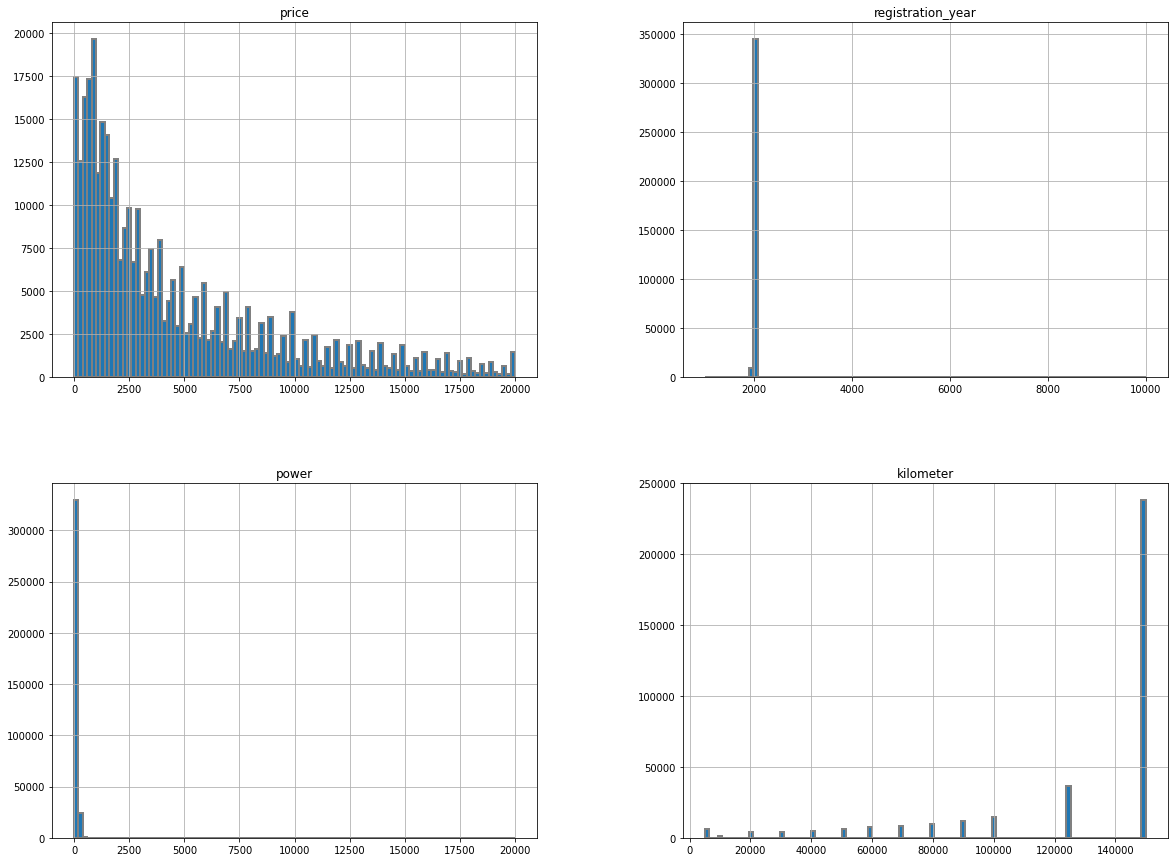

In [15]:
df.hist(bins=100, figsize=(20,15), edgecolor='grey', linewidth=2)
plt.show()

In [16]:
df.describe()

,price,registration_year,power,kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Аномалии в признаках мощность и год регистрации, также есть проблемы с целевым столбцом цены - есть нулевые значения.

год регистрации не может быть больше 2022, и маловероятно может быть меньше 1943 (довоенного времени).
Макисмальную мощность ограничим 1000 л.с. (большинство тягачей и фур имеют мощность до 1000)

аномалии registration_year

<AxesSubplot:xlabel='registration_year'>

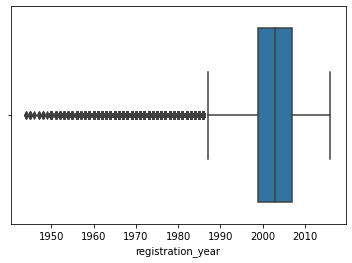

In [17]:
df=df.loc[(df['registration_year']>1943)& (df['registration_year']<2017)]
sns.boxplot(df['registration_year'])

аномалии power

<AxesSubplot:xlabel='power'>

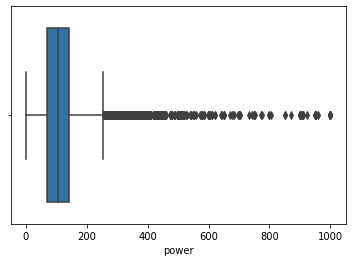

In [18]:
df=df.loc[(df['power']>=0)&(df['power']<1001)]
sns.boxplot(df['power'])

аномалии price. Установим минимально значение в 50 евро. Такое возможно если авто не на ходу и продается на запчасти либо на лом.

<AxesSubplot:xlabel='price'>

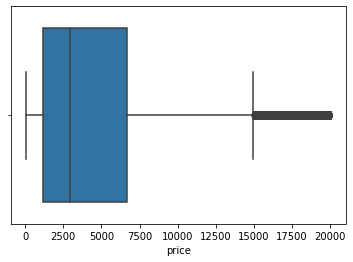

In [19]:
df=df.loc[(df['price'] > 50)]
sns.boxplot(df['price'])


<div class="alert alert-block alert-info">
<b>Совет:</b>  
Самое интересное, что на нескольких сайтов по продажам подержанных автомобилей в Германии (страну можно определить по почтовым индексам, большинство из них из Германии) показало, что цены начинаются действительно с 0 и 1 евро, но это единичные объявления и не понятно, то ли это ошибка при заполнении формы, то ли машины на металлолом. Но я  все-таки склоняюсь к тому, чтобы избавиться от таких данных
</div>


In [20]:
df.describe()

,price,registration_year,power,kilometer
count,327519.000000,327519.000000,327519.000000,327519.000000
mean,4634.171294,2002.640934,109.008992,128357.225077
std,4545.968062,6.740362,63.151211,37266.417489
min,55.000000,1944.000000,0.000000,5000.000000
25%,1200.000000,1999.000000,71.000000,125000.000000
50%,2950.000000,2003.000000,105.000000,150000.000000
75%,6700.000000,2007.000000,143.000000,150000.000000
max,20000.000000,2016.000000,1000.000000,150000.000000


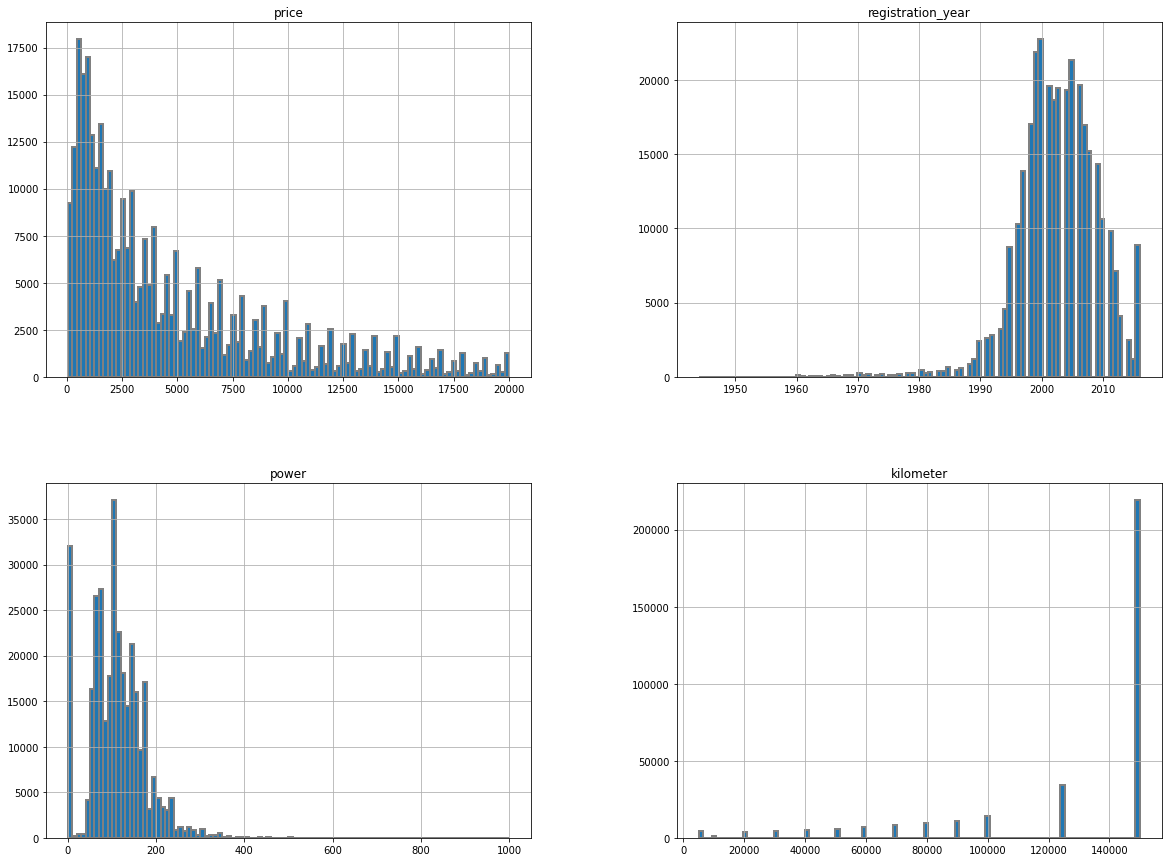

In [21]:
df.hist(bins=100, figsize=(20,15), edgecolor='grey', linewidth=2)
plt.show()

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327519 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              327519 non-null  int64 
 1   vehicle_type       327519 non-null  object
 2   registration_year  327519 non-null  int64 
 3   gearbox            327519 non-null  object
 4   power              327519 non-null  int64 
 5   model              327519 non-null  object
 6   kilometer          327519 non-null  int64 
 7   fuel_type          327519 non-null  object
 8   brand              327519 non-null  object
 9   not_repaired       327519 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.5+ MB


In [23]:
df.sample(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
118931,3899,convertible,2003,manual,147,astra,125000,petrol,opel,no
162226,1950,sedan,1999,manual,116,beetle,150000,petrol,volkswagen,no
20721,4250,sedan,2001,manual,118,3er,150000,petrol,bmw,no
305250,1150,small,2000,manual,60,punto,150000,petrol,fiat,no
56058,1799,sedan,1998,manual,75,golf,150000,petrol,volkswagen,no
10264,10950,sedan,2011,manual,105,golf,100000,gasoline,volkswagen,no
175902,2390,bus,2004,manual,118,c_max,150000,gasoline,ford,no
19048,450,bus,1997,manual,75,berlingo,150000,unknown,citroen,unknown
257059,8500,bus,2011,manual,120,other,125000,gasoline,peugeot,no
354310,1650,bus,2002,manual,66,vito,150000,gasoline,mercedes_benz,no


**Вывод**

Данные готовы для обучения.

На этапе исследования были выявлены аномалии, дубликаты, пропуски, удалены неинформативные признаки.

- дубликаты удалены
- пропуски были заменены на unknown
- аномалии обработаны

## Обучение моделей

### Разделим и закодируем выборки

разделим выборку на тестовую и обучающую

In [24]:
features_train, features_test, target_train, target_test = train_test_split(
    df.drop(['price'], axis=1), df['price'], test_size=0.25, random_state=42)

перекодируем категориальные признаки

In [25]:
ce_ord = ce.OrdinalEncoder(cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired'])
features_train = ce_ord.fit_transform(features_train, target_train)
features_test = ce_ord.transform(features_test, target_test)

In [26]:
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train, target_train)
features_test = scaler.fit_transform(features_test, target_test)

Функция вычисления RMSE

In [27]:
def RMSE(target,predictions):
    MSE = mean_squared_error(target, predictions)
    return MSE ** 0.5
RMSE_score = make_scorer(RMSE, greater_is_better=False)

Функция вычисления времени обучения модели, времени предсказания модели, а так же RMSE и оценка для кросс-валидации

In [28]:
def best_model(model, params, features_train, target_train):
    grid = GridSearchCV(model, param_grid = params, cv=3)
    grid.fit(features_train,target_train)
    predict = grid.predict(features_test) 
    return (grid.cv_results_['mean_fit_time'][grid.best_index_],
            grid.cv_results_['mean_score_time'][grid.best_index_],
            grid.cv_results_['mean_test_score'][grid.best_index_], RMSE(target_test, predict))

### catboost

In [29]:
catboost_params = {
    'learning_rate': [0.1],
    'iterations': [10,50,100],
    'max_depth': [10,20]
}
catboost_model = CatBoostRegressor(random_state=42,silent=True)

In [30]:
CatBoost = best_model(catboost_model, catboost_params, features_train, target_train)

In [38]:
CatBoost

(5.766357024510701,
 0.18820500373840332,
 0.8557888332490782,
 1708.8915017677616)

### LightGBM

In [31]:
LightGBM_params = {
    'n_estimators': [10,50,100],
    'max_depth': [15,30],
    'num_leaves': [10,20,31],
    'learning_rate': [0.1]
}
LightGBM_reg_model = LGBMRegressor(random_state=42)

In [32]:
LightGBM = best_model(LightGBM_reg_model, LightGBM_params, features_train, target_train)

### RandomForest

In [33]:
RF_model = RandomForestRegressor(random_state=42)
forestregressor_params = {'n_estimators':range(10, 51, 10),
             'max_depth':range (1,10)}

In [34]:
RandomForest = best_model(RF_model, forestregressor_params, features_train, target_train)

## Анализ моделей

In [40]:
table = pd.DataFrame([LightGBM, CatBoost, RandomForest], 
             columns=['mean_fit_time', 'mean_score_time', 'mean_test_score', 'RMSE'], 
                      index=['LightGBM','CatBoost', 'RandomForest'])
table

,mean_fit_time,mean_score_time,mean_test_score,RMSE
LightGBM,4.860948,0.643327,0.856542,1721.119366
CatBoost,5.766357,0.188205,0.855789,1708.891502
RandomForest,10.282981,0.321740,0.816915,1951.322916


In [ ]:
CatBoost = best_model(catboost_model, catboost_params, features_train, target_train)

На базе полученных результатов можно сделать вывод, что наименьшую ошибку выдает CatBoost. (RMSE модели LightGBM почти такое же). Однако Время обучения и предсказания у модели CatBoost заметно меньше.
 
Основываясь на всем вышеперечисленном, можно сделать вывод, что лучше всего подойдет модель построенная на **CatBoost**.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей